# Face Recognition model Training notebook

In [13]:
# It trains face images using a simple CNN structure and exports a *.pb file.
# The pb file can be used in OpenCV applications.

import argparse
import os
import sys

import numpy as np
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import cv2

from tensorflow.python.framework import graph_util
from tensorflow.python.platform import gfile

import matplotlib.pyplot as plt

FLAGS = None
tf.logging.set_verbosity(tf.logging.ERROR)

train_img_dir = '../data'
categories = [name for name in os.listdir(train_img_dir) if os.path.isdir(os.path.join(train_img_dir, name))]
categories.sort()

extensions = ['png', 'jpg']  # lower case only

# Parameters
img_w = 150
img_h = 200
img_c = 1
num_cls = len(categories)

    
# for plotting
loss_list = []

# Helper functions
def create_image_list(image_dir):
    '''Builds a list of training images from the file system.

    Create image list in the image_dir directory.
    The image_dir should contains two sub directories named non_repeat and repeat.
    Using image files in these sub directories, a list will be created and returned.

    Args:
        image_dir: sub directory name

    Returns:
        The list elements contains a string and an integer.
        The string contains the relative path for image file
        and the integer must be 0(non_integer) or 1(repeat)
    '''
    if not os.path.exists(image_dir):
        print('Error:', image_dir, 'is not exist!')
        return None

    image_list = []
    for label, category in enumerate(categories):
        filelist = os.listdir(os.path.join(image_dir, category))
        for f in filelist:
            dotext = os.path.splitext(f)[-1]
            ext = dotext[1:]
            if ext.lower() not in extensions:
                continue

            filepath = os.path.join(image_dir, category, f)
            image_list.append([filepath, label])

    return image_list


def read_image(path):
    '''Read an image in the path.

    Args:
        path: image file path

    Returns:
        The pixel value is normalized to be [0, 1].
        The image size is (img_w x img_h).
    '''
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) / 255.

    if img.shape != (img_h, img_w):
        img = cv2.resize(img, (img_w, img_h))

    return img.reshape(img_h, img_w, img_c)


def batch(paths, idx, batch_size):
    '''Get a batch from image lists.

    Args:
        paths: image list
        idx: index
        batch_size: batch size

    Returns:
        Subset of image list starts from (idx * batch_size)
    '''
    num_imgs = len(paths)
    idx1 = idx * batch_size
    idx2 = (idx + 1) * batch_size
    if idx2 > num_imgs:
        idx2 = num_imgs
    batch_list = paths[idx1: idx2]

    imgs, labels = [], []
    for i in range(batch_size):
        imgs.append(read_image(batch_list[i][0]))
        labels.append(batch_list[i][1])
    return imgs, labels


def main(argv):

    # Load images
    train_list = create_image_list(train_img_dir)
    if train_list is None:
        return

    print('Total number of train images:', len(train_list))

    # Model configuration
    tf.disable_eager_execution()

    X = tf.placeholder(tf.float32, [None, img_h, img_w, img_c], name='data')
    Y = tf.placeholder(tf.int32, [None])
    
    conv0 = tf.layers.conv2d(X, 16, [3, 3], padding='same', activation=tf.nn.relu)
    conv0_1 = tf.layers.conv2d(conv0, 16, [3, 3], padding='same', activation=tf.nn.relu)
    pool0 = tf.layers.max_pooling2d(conv0_1, [2, 2], strides=2) 
    
    conv1 = tf.layers.conv2d(X, 64, [3, 3], padding='same', activation=tf.nn.relu)
    conv1_1 = tf.layers.conv2d(conv1, 64, [3, 3], padding='same', activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(conv1_1, [2, 2], strides=2)

    conv2 = tf.layers.conv2d(pool1, 128, [3, 3], padding='same', activation=tf.nn.relu)
    conv2_1 = tf.layers.conv2d(conv2, 128, [3, 3], padding='same', activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(conv2_1, [2, 2], strides=2)

    conv3 = tf.layers.conv2d(pool2, 256, [3, 3], padding='same', activation=tf.nn.relu)
    conv3_1 = tf.layers.conv2d(conv3, 256, [3, 3], padding='same', activation=tf.nn.relu)
    pool3 = tf.layers.max_pooling2d(conv3, [2, 2], strides=2)

    conv4 = tf.layers.conv2d(pool3, 512, [3, 3], padding='same', activation=tf.nn.relu)
    conv4_1 = tf.layers.conv2d(conv4, 512, [3, 3], padding='same', activation=tf.nn.relu)
    pool4 = tf.layers.max_pooling2d(conv4, [2, 2], strides=2)    
    
    conv5 = tf.layers.conv2d(pool3, 12, [3, 3], activation=tf.nn.relu)
    #pool3 = tf.layers.max_pooling2d(conv3, [2, 2], strides=2)

    flat1 = tf.layers.flatten(conv5)
    dense1 = tf.layers.dense(flat1, 512, activation=tf.nn.relu)
    dense2 = tf.layers.dense(flat1, 512, activation=tf.nn.relu)

    logits = tf.layers.dense(dense2, num_cls, activation=None)
    final_tensor = tf.nn.softmax(logits, name='prob')

    cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=logits))
    optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate).minimize(cost)


    # Training
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        total_batch = int(len(train_list) / FLAGS.batch_size)
        print('Total batch count:', total_batch)

        print('Start learning!')
        for epoch in range(FLAGS.num_epochs):

            total_cost = 0
            np.random.shuffle(train_list)

            for i in range(total_batch):
                imgs, labels = batch(train_list, i, FLAGS.batch_size)
                _, cost_val = sess.run([optimizer, cost], feed_dict={X: imgs, Y: labels})
                total_cost += cost_val

            print('Epoch: %d, cost: %.8f' % ((epoch + 1), total_cost))

            if (total_cost < FLAGS.minimum_cost):
                print('Learning stoped because cost <', FLAGS.minimum_cost)
                break
                
            # for plotting
            loss_list.append(total_cost)

        print('Learning finished!')

        # Freeze variables and save pb file
        output_graph_def = graph_util.convert_variables_to_constants(
            sess, sess.graph_def, ['prob'])
        with gfile.FastGFile(FLAGS.output_model, 'wb') as f:
            f.write(output_graph_def.SerializeToString())

    input('Press Enter to continue...')
    

In [14]:
parser = argparse.ArgumentParser()
parser.add_argument(
    '--num_epochs',
    type=int,
    default=200,
    help='Number of epochs to run trainer.'
)
parser.add_argument(
    '--learning_rate',
    type=float,
    default=0.0001,
    help='How large a learning rate to use when training.'
)
parser.add_argument(
    '--batch_size',
    type=int,
    default=30,
    help='How many images to train on at a time.'
)
parser.add_argument(
    '--minimum_cost',
    type=float,
    default=0.000001,
    help='Minimum cost to stop learning.'
)
parser.add_argument(
    '--output_model',
    type=str,
    default='./face_rec.pb',
    help='Output model file name.'
)
FLAGS, unparsed = parser.parse_known_args(args=[])

tf.app.run(main=main, argv=[sys.argv[0]] + unparsed)

Total number of train images: 1713


/home/jeongseobkim/anaconda3/envs/vision/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
/home/jeongseobkim/anaconda3/envs/vision/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/home/jeongseobkim/anaconda3/envs/vision/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/pooling.py:310: UserWarning: `tf.layers.max_pooling2d` is deprecated and will be removed in a future version. Please use `tf.keras.layers.MaxPooling2D` instead.
  warnings.warn('`tf.layers.max_pooling2d` is deprecated and '
/home/jeongseobkim/anaconda3/envs/vision/lib/p

Total batch count: 57
Start learning!
Epoch: 1, cost: 29.55746614
Epoch: 2, cost: 2.41485884
Epoch: 3, cost: 0.59530062
Epoch: 4, cost: 0.58337315
Epoch: 5, cost: 0.59186038
Epoch: 6, cost: 0.76512795
Epoch: 7, cost: 0.17097515
Epoch: 8, cost: 0.01143383
Epoch: 9, cost: 0.50760043
Epoch: 10, cost: 0.26096672
Epoch: 11, cost: 0.28975922
Epoch: 12, cost: 0.19287805
Epoch: 13, cost: 0.00984182
Epoch: 14, cost: 0.01129457
Epoch: 15, cost: 0.00166512
Epoch: 16, cost: 0.00028907
Epoch: 17, cost: 0.00024648
Epoch: 18, cost: 0.00027034
Epoch: 19, cost: 0.00019863
Epoch: 20, cost: 0.00021125
Epoch: 21, cost: 0.00017506
Epoch: 22, cost: 0.00016288
Epoch: 23, cost: 0.00015094
Epoch: 24, cost: 0.00014272
Epoch: 25, cost: 0.00013547
Epoch: 26, cost: 0.00012732
Epoch: 27, cost: 0.00012127
Epoch: 28, cost: 0.00011397
Epoch: 29, cost: 0.00010746
Epoch: 30, cost: 0.00010154
Epoch: 31, cost: 0.00009689
Epoch: 32, cost: 0.00009083
Epoch: 33, cost: 0.00008676
Epoch: 34, cost: 0.00008213
Epoch: 35, cost: 0

SystemExit: 

/home/jeongseobkim/anaconda3/envs/vision/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


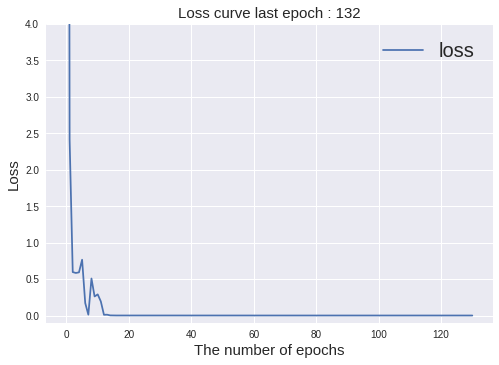

In [15]:
ymin, ymax = -0.1, 4
img_name = 'Loss curve last epoch'

plt.plot(loss_list, label='loss')
plt.ylabel('Loss', fontsize=15)
plt.xlabel('The number of epochs', fontsize=15)
plt.title(f"{img_name} : {len(loss_list)+1}", fontsize=15)
plt.ylim(ymin, ymax)
plt.style.use("seaborn")
plt.legend(fontsize=20)
plt.show()